In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sns
import anndata

import matplotlib.pyplot as plt
%matplotlib inline

save_path = "/home/ubuntu/destVI-paper-code/lymph_node/spatial/"

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3

plt.rcParams['lines.linewidth'] = 1.7
DPI = 300

### Load data

In [6]:
adata_C = sc.read_visium(save_path + "C1")
adata_C.var_names_make_unique()

adata_D = sc.read_visium(save_path + "D1")
adata_D.var_names_make_unique()

adata = adata_C.concatenate(adata_D, batch_key='batch')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
# manual lasso selection of each LN in VISION
LN_top_C = [barcode + "-0" for barcode in pd.read_csv(save_path + "barcodes/barcode_LN_top_C1.txt", header=None)[0].values]
LN_top_D = [barcode + "-1" for barcode in pd.read_csv(save_path + "barcodes/barcode_LN_top_D1.txt", header=None)[0].values]

In [8]:
adata.obs["batch"][0]

'0'

### Deal with lymph nodes segmentation

In [9]:
l = []
slice_name = ["C", "D"]
for i in range(adata.n_obs):
    local = "B" + slice_name[int(adata.obs["batch"][i])]
    if adata.obs_names[i] in LN_top_C:
        local = "TC"
    elif adata.obs_names[i] in LN_top_D:
        local = "TD"
    l.append(local)
adata.obs["LN"] = l    

In [10]:
adata.obs

,in_tissue,array_row,array_col,batch,LN
AAACCGGGTAGGTACC-1-0,1,42,28,0,TC
AAACCTCATGAAGTTG-1-0,1,37,19,0,TC
AAACGAAGAACATACC-1-0,1,6,64,0,BC
AAAGACCCAAGTCGCG-1-0,1,10,48,0,BC
AAAGACTGGGCGCTTT-1-0,1,29,15,0,TC
...,...,...,...,...,...
TTGGTCACACTCGTAA-1-1,1,48,48,1,TD
TTGTAAGGCCAGTTGG-1-1,1,27,81,1,BD
TTGTAATCCGTACTCG-1-1,1,35,55,1,TD
TTGTATCACACAGAAT-1-1,1,12,74,1,BD


In [11]:
adata.obs["LN"].value_counts()

BC    439
TC    402
TD    375
BD    323
Name: LN, dtype: int64

In [12]:
# now modify coordinates to fit into a single image
coordinates = np.zeros(shape=(adata.n_obs, 2))
for ln in ("TC", "BC", "TD", "BD"):
    mask = adata.obs["LN"] == ln
    for ax, name in ([0, "x"], [1, "y"]):
        data = adata[mask].obsm["spatial"][:, ax]
        normalized_locations = data - data.min() + 100
        if ln[0] == "B" and name == "y":
            normalized_locations *= -1
        elif ln[1] == "C" and name == "x":
            normalized_locations *= -1
        coordinates[mask, ax] = normalized_locations
        print(ln, name, data.min(), data.max())

TC x 3011 6516
TC y 5284 9204
BC x 5195 9850
BC y 2927 5945
TD x 4941 9092
TD y 7109 9957
BD x 7675 11099
BD y 3693 7021


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
adata.obsm["location"] = coordinates

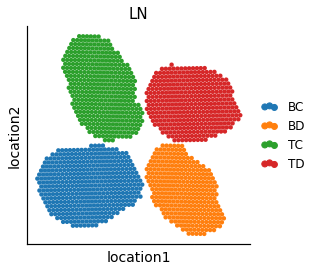

In [18]:
sc.pl.embedding(adata, basis="location", color="LN")

### perform quality control

In [15]:
adata.var["mt"] = adata.var_names.str.startswith("mt")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [16]:
adata.obs

,in_tissue,array_row,array_col,batch,LN,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCGGGTAGGTACC-1-0,1,42,28,0,TC,6317,8.751158,23755.0,10.075590,17.436329,26.263944,34.725321,46.886971,185.0,5.225747,0.778783
AAACCTCATGAAGTTG-1-0,1,37,19,0,TC,6365,8.758727,22583.0,10.024997,15.839348,23.747952,32.303060,44.883319,196.0,5.283204,0.867909
AAACGAAGAACATACC-1-0,1,6,64,0,BC,1069,6.975414,1437.0,7.271008,17.745303,25.817676,39.526792,60.403619,5.0,1.791759,0.347947
AAAGACCCAAGTCGCG-1-0,1,10,48,0,BC,2413,7.789040,4336.0,8.374938,16.351476,25.046125,35.124539,51.499077,22.0,3.135494,0.507380
AAAGACTGGGCGCTTT-1-0,1,29,15,0,TC,4843,8.485496,12517.0,9.434923,15.187345,22.976752,31.780778,45.042742,94.0,4.553877,0.750979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTCACACTCGTAA-1-1,1,48,48,1,TD,3737,8.226306,8823.0,9.085231,17.817069,26.918282,36.223507,50.289017,53.0,3.988984,0.600703
TTGTAAGGCCAGTTGG-1-1,1,27,81,1,BD,4576,8.428799,11285.0,9.331318,18.085955,25.467435,33.389455,46.335844,60.0,4.110874,0.531679
TTGTAATCCGTACTCG-1-1,1,35,55,1,TD,3609,8.191463,8279.0,9.021598,18.057736,26.537021,35.426984,49.534968,35.0,3.583519,0.422756
TTGTATCACACAGAAT-1-1,1,12,74,1,BD,3975,8.288032,8950.0,9.099521,19.374302,26.603352,34.625698,47.553073,97.0,4.584968,1.083799


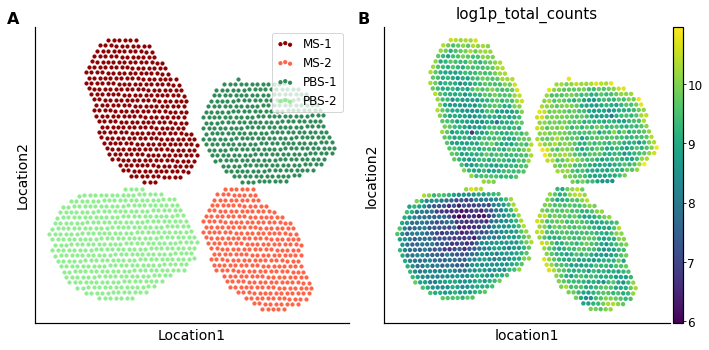

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_list = ["darkred", "tomato", "seagreen", "lightgreen"]
name_list = ["MS-1", "MS-2", "PBS-1", "PBS-2"]
ax = axes[0]
ax.text(-0.05, 1.05, "A", transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
for i, value in enumerate(["TC", "BD", "TD", "BC"]):
    mask = adata.obs["LN"] == value
    ax.scatter(adata.obsm["location"][mask, 0], adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=10)
ax.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Location1")
ax.set_ylabel("Location2")

sc.pl.embedding(adata, basis="location", color=["log1p_total_counts"], show=False, ax=axes[1])
axes[1].text(-0.05, 1.05, "B", transform=axes[1].transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.savefig("quality_control.png")

In [13]:
for ln in adata.obs["LN"].unique():
    res = np.mean(adata[adata.obs["LN"] == ln].obs["n_genes_by_counts"])
    print(f"n_genes_by_counts for LN {ln}: {res:.2f}")

n_genes_by_counts for LN TC: 4713.77
n_genes_by_counts for LN BC: 2531.63
n_genes_by_counts for LN TD: 5071.53
n_genes_by_counts for LN BD: 4823.91


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [14]:
# now filter the low-quality LN (LN BC)
adata = adata[adata.obs["LN"] != "BC"].copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 1100 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'LN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'LN_colors'
    obsm: 'spatial', 'location'

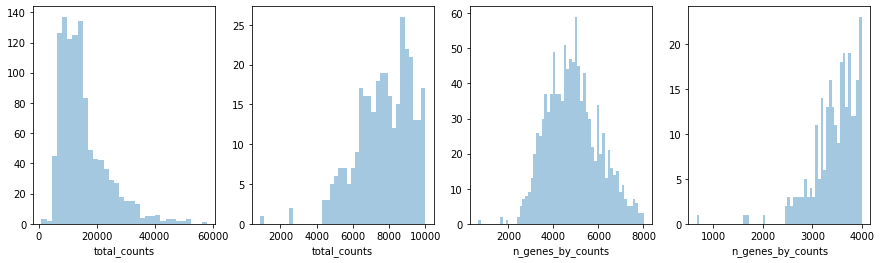

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
plt.show()

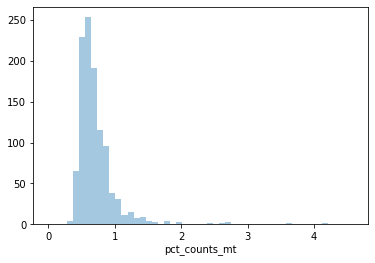

In [17]:
sns.distplot(adata.obs["pct_counts_mt"], kde=False)
plt.show()

In [18]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=50000)
print(f"#cells after filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after filter: 1092


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Pass through filtering / PCA / UMAP

In [19]:
normalized = adata.copy()
sc.pp.normalize_total(normalized, target_sum=1e4)
sc.pp.log1p(normalized)
sc.pp.highly_variable_genes(normalized, flavor="seurat", n_top_genes=1000)

In [20]:
sc.pp.pca(normalized, svd_solver='arpack')
sc.pp.neighbors(normalized, n_neighbors=10, n_pcs=40)
sc.tl.leiden(normalized)
sc.tl.umap(normalized)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


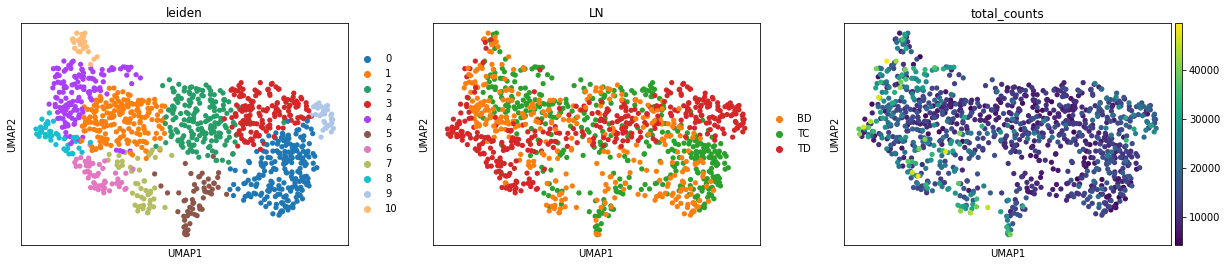

In [21]:
sc.pl.umap(normalized, color=["leiden", "LN", "total_counts"])

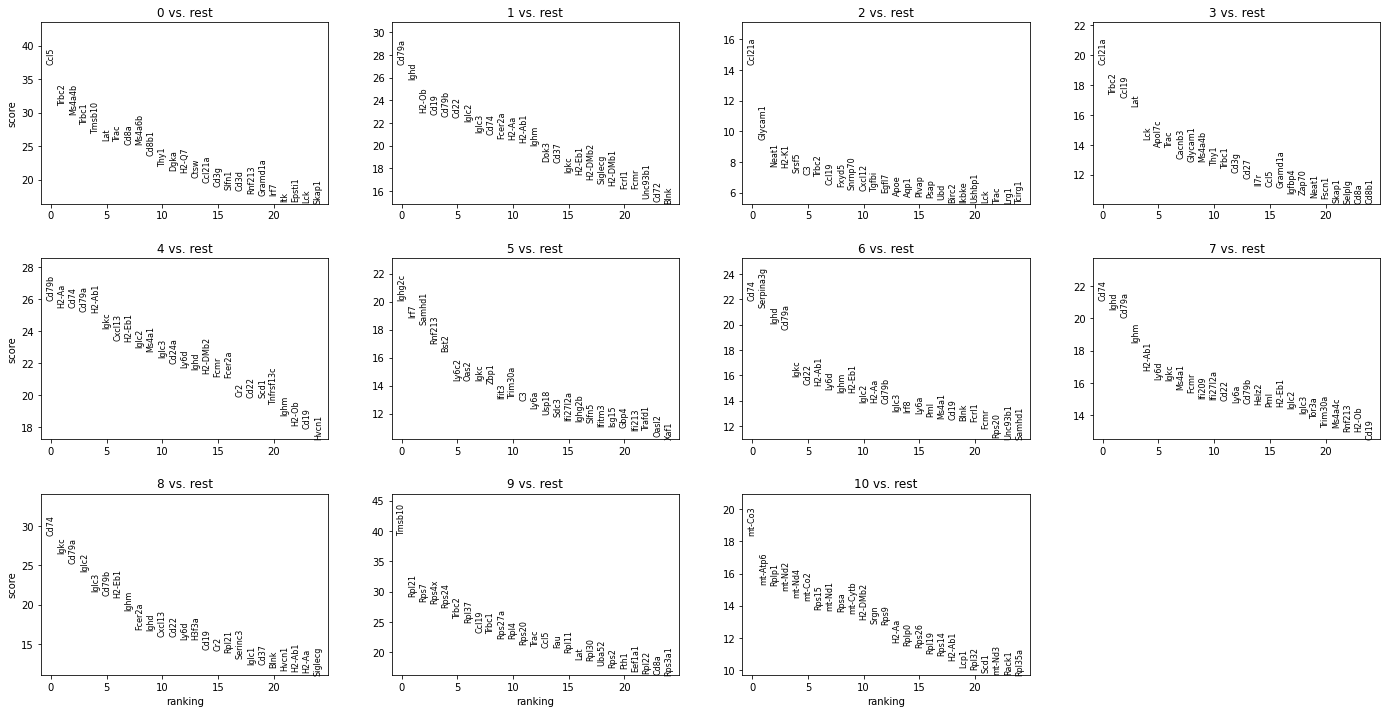

In [27]:
sc.tl.rank_genes_groups(normalized, 'leiden', method='t-test')
sc.pl.rank_genes_groups(normalized, n_genes=25, sharey=False)

In [54]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


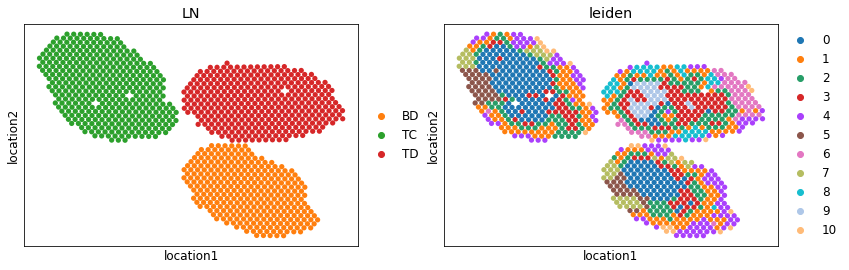

In [55]:
sc.pl.embedding(adata, basis="location", color=["LN", "leiden"], save="leiden")

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


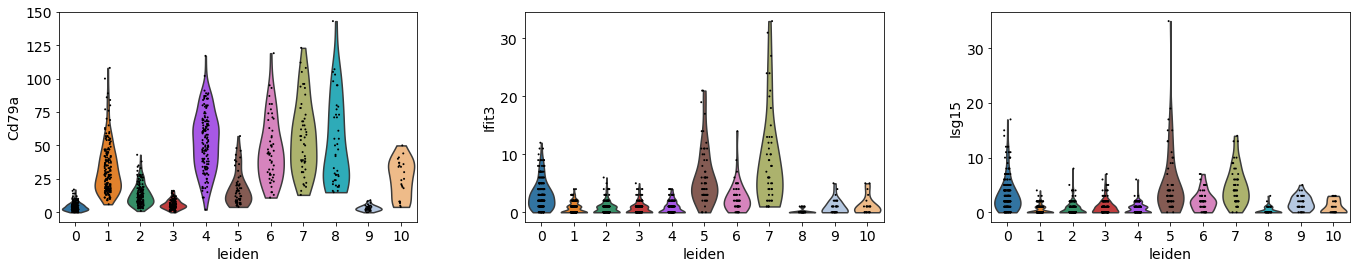

In [52]:
sc.pl.violin(adata, [ "Cd79a", 'Ifit3', 'Isg15'], groupby='leiden', save="leidengenes", size=2, )

In [38]:
marker_genes = ['Ifit3', 'Isg15', 'Cxcl10', "Cd79a"]

In [ ]:
sc.pl.violin(adata, ["Cd79a", "Cd74", ""]

In [22]:
adata.obsm["X_pca"] = normalized.obsm["X_pca"]
adata.obsm["X_umap"] = normalized.obsm["X_umap"]
adata.obs["leiden"] = normalized.obs["leiden"]

### give hotspot a shot

In [24]:
import hotspot
counts = pd.DataFrame(data=adata.X.T.A, columns=adata.obs_names, index=adata.var_names)
pos = pd.DataFrame(
    {
        'X': adata.obsm["location"][:, 0],
        'Y': adata.obsm["location"][:, 1],
    }, index=adata.obs_names
)
num_umi = np.sum(counts, axis=0)


hs = hotspot.Hotspot(counts, model='bernoulli', latent=pos, umi_counts=num_umi)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [30]:
hs_results = hs.compute_autocorrelations(jobs=1)

hs_results.head()

100%|██████████| 13948/13948 [00:13<00:00, 997.30it/s] 


,C,Z,Pval,FDR
Gene,,,,
Ighg1,0.307442,39.536892,0.000000e+00,0.000000e+00
Ighg2c,0.292348,38.249938,0.000000e+00,0.000000e+00
Srpk3,0.232877,32.348841,7.202007e-230,3.348453e-226
Ifit1,0.223561,29.077691,3.437265e-186,1.198574e-182
Isg15,0.224588,28.905617,5.074001e-184,1.415443e-180


In [31]:
# Select the genes with significant spatial autocorrelation
hs_genes = hs_results.index[hs_results.FDR < 0.05]
hs_genes

Index(['Ighg1', 'Ighg2c', 'Srpk3', 'Ifit1', 'Isg15', 'Ifit3', 'Jchain',
       'Dapl1', 'Bcar3', 'Pxdc1',
       ...
       'Acaa1b', 'Cbr2', 'Anxa6', 'Cpt1a', 'Notch3', 'Mlx', 'H2afz',
       'Olfr1033', 'Fgf10', 'Hmgcll1'],
      dtype='object', name='Gene', length=2515)

In [34]:
# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

  4%|▍         | 109/2515 [00:00<00:02, 1081.60it/s]

Computing pair-wise local correlation on 2515 features...


100%|██████████| 3161355/3161355 [05:13<00:00, 10071.00it/s]


In [35]:
modules = hs.create_modules(
    min_gene_threshold=20, core_only=False, fdr_threshold=0.05
)

modules.value_counts()

-1     543
 1     453
 4     238
 6     231
 2     156
 3     123
 18    103
 5      81
 19     59
 7      56
 10     50
 14     49
 11     44
 20     42
 8      41
 9      39
 12     39
 16     33
 15     33
 13     29
 17     28
 21     24
 22     21
Name: Module, dtype: int64

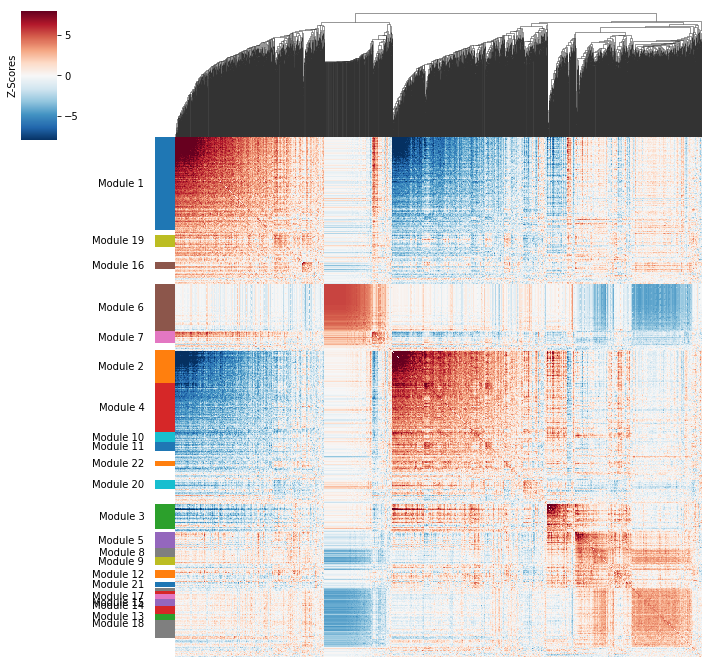

In [36]:
hs.plot_local_correlations()

In [37]:
# Show the confidence for a module and flag low confidence modules
high_confidence = []
for i in range(1, 23):
    module = i
    results = hs.results.join(hs.modules)
    results = results.loc[results.Module == module]
    mean_FDR = results.sort_values('Z', ascending=False).head(20)["FDR"].mean()
    print(i, mean_FDR)
    if mean_FDR < 0.001:
        high_confidence.append(i)

1 3.554139104665028e-74
2 4.077799857696722e-65
3 1.8317045174254418e-45
4 3.3211670754632784e-16
5 1.211164744527147e-15
6 0.0023271457374603377
7 0.0002976948724694114
8 0.0013518915823449418
9 0.012743975216629986
10 0.0001804727998146449
11 0.00010041917653329937
12 1.2475110653198384e-05
13 0.022882559640849787
14 0.02029305721819567
15 0.027339016170330233
16 0.002394827980673649
17 0.02498825331305588
18 0.011415726176140353
19 0.0003957994808816776
20 0.0009637839678302907
21 0.006895355160102356
22 0.007416200939765821


In [38]:
# Show the top genes for a module
signature = []
for i in high_confidence:
    print(i)
    module = i
    results = hs.results.join(hs.modules)
    results = results.loc[results.Module == module]
    signature.append("Hotspot_" + str(i) + "\tHotspot\t" + "\t".join(results.sort_values('Z', ascending=False).head(20).index.values))
    print(results.sort_values('Z', ascending=False).head(20))

1
                  C          Z           Pval            FDR  Module
Gene                                                                
Srpk3      0.232877  32.348841  7.202007e-230  3.348453e-226     1.0
Bcar3      0.190394  25.560242  2.112302e-144  3.273599e-141     1.0
Pxdc1      0.187906  25.153972  6.393121e-140  8.917126e-137     1.0
Tnfrsf13c  0.190715  24.373240  1.644001e-131  1.763886e-128     1.0
Chst3      0.181388  23.254302  6.434477e-120  5.279299e-117     1.0
Lyl1       0.169448  22.584219  3.097175e-113  2.273652e-110     1.0
Lat2       0.167940  21.900656  1.280343e-106  8.117373e-104     1.0
Cyp4f18    0.161803  21.779820  1.802435e-105  1.093059e-102     1.0
Vpreb3     0.160629  21.305680  5.027826e-101   2.805124e-98     1.0
Cr2        0.155805  20.563127   2.936176e-94   1.462635e-91     1.0
Fcrl1      0.162895  20.347635   2.436104e-92   1.171682e-89     1.0
Rasgrp3    0.147805  19.835775   7.312271e-88   3.290050e-85     1.0
Fcrla      0.149228  19.663012  

In [39]:
#save signatures files
with open("/home/ubuntu/mouse_lymph_node/signatures/Hotspot.gmt", "w") as text_file:
    text_file.write("\n".join(signature))

In [40]:
module_scores = hs.calculate_module_scores()

  0%|          | 0/22 [00:00<?, ?it/s]

Computing scores for 22 modules...


100%|██████████| 22/22 [00:04<00:00,  4.98it/s]


In [41]:
module_scores = module_scores[high_confidence].add_prefix('hotspot_')
module_scores.head()

,hotspot_1,hotspot_2,hotspot_3,hotspot_4,hotspot_5,hotspot_7,hotspot_10,hotspot_11,hotspot_12,hotspot_19,hotspot_20
AAACCGGGTAGGTACC-1-0,2.082462,-0.317649,0.436854,0.505647,0.261704,0.441063,-0.617094,-0.219031,-0.928814,1.249213,0.217821
AAACCTCATGAAGTTG-1-0,2.687751,-0.141439,-0.277500,-0.230224,0.347652,0.693352,-0.389515,0.393112,-0.286963,1.429427,0.257310
AAAGACTGGGCGCTTT-1-0,2.280615,-1.263070,-2.747936,-0.227777,-0.192910,0.441462,-0.552333,0.957271,-0.164271,1.683454,-0.908563
AAAGGGCAGCTTGAAT-1-0,-2.807445,2.668091,-0.513297,2.073560,-0.161004,-0.042982,0.160485,0.414319,-0.143640,0.206360,0.736308
AAAGTCGACCCTCAGT-1-0,4.368533,-2.033152,-1.093918,-1.685633,0.375399,0.625825,-0.881145,-0.288519,-0.429190,1.515512,0.194258


In [42]:
adata.obsm["modules"] = module_scores

In [128]:
#delete spatial information
# del adata.obsm["spatial"]

In [44]:
sc.write(save_path + "save/joint.h5ad", adata)